<a href="https://colab.research.google.com/github/Anoif01/Sentiment-Analysis-FrozenLayer/blob/test-colab/FrozenLayer_IMDB_Sentiment_Analysis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is an experimental Notebook on the topic of sentiment analysis tasks in the field of NLP.
### The main tools used are Pytorch and tensorflows.
### Topic studied here:

1. 如何调用Bert模型：使用什么库，什么函数？

In [1]:
!pip install wandb
!pip install datasets
!pip install pyarrow==11.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.8/257.8 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framewo

In [2]:
import os
import random
import gc

import numpy as np
import pandas as pd
from tqdm import tqdm
import re
from argparse import Namespace
from matplotlib import pyplot as plt

import wandb

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

from transformers import AutoModel, AutoTokenizer, AutoConfig, AdamW
from datasets import load_dataset

gc.collect()

0

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 0. Set the SEED value for reproducing the experiment.

In [4]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

In [5]:
wb_log = False # @param {type:"boolean"}

args = Namespace()
args.model_name = 'bert-base-uncased' # @param
args.dataset_name = 'imdb' # @param
args.max_length = 500 # @param
args.bs = 128 # @param
args.N=8 # @param
args.forze_embed=True #
args.lr=2e-5 # @param
args.epoch = 10 # @param

if wb_log:
  wandb.login()
  # wandb.init(project='Sentiment-Analysis-FrozenLayer', entity='anoif')

  run = wandb.init(
      # Set the project where this run will be logged
      project="Sentiment-Analysis-FrozenLayer",
      name="IMDB-test",
      # Track hyperparameters and run metadata
      config=vars(args),
  )

## 1. Prepare data

###Data Fields
The data fields are the same among all splits.

###Columns
- text: a string feature.

- label: a classification label, with possible values including **neg (0), pos (1)**.

In [29]:
# 加载IMDb数据集
dataset = load_dataset("imdb", num_proc=3)
print(dataset)

# Check if the positive and negative classes of the training and test datasets are balanced
labels, counts = np.unique(dataset['train']['label'], return_counts = True)
print(f"We have {len(labels)} labels in train dataset: {labels}.\nCounts of each label: {dict(zip(labels, counts))}")

labels, counts = np.unique(dataset['test']['label'], return_counts = True)
print(f"We have {len(labels)} labels in test dataset: {labels}.\nCounts of each label: {dict(zip(labels, counts))}")

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
We have 2 labels in train dataset: [0 1].
Counts of each label: {0: 12500, 1: 12500}
We have 2 labels in test dataset: [0 1].
Counts of each label: {0: 12500, 1: 12500}


233.77672
174.0


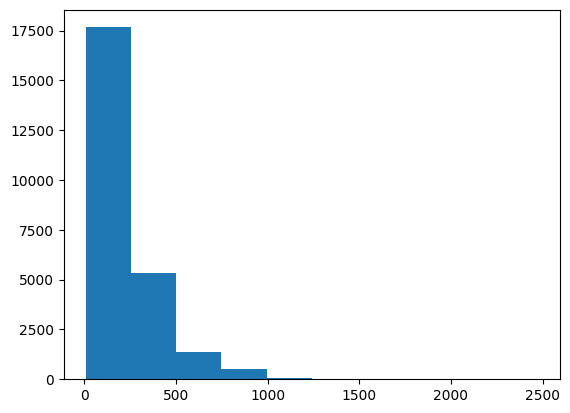

In [30]:
train_texts_lengths = []
for text in dataset['train']['text']:
    split_text = text.split(' ')
    train_texts_lengths.append(len(split_text))
plt.hist(train_texts_lengths)
print(np.mean(train_texts_lengths))
print(np.median(train_texts_lengths))

In [19]:
del dataset

### 2. Text Processing

In [20]:
def clean_data(example):
  text = example['text']
  # remove HTML<...>
  cleaned_text = re.sub(r"<.*?>", "", text)
  cleaned_text = cleaned_text.lower()
  # remove ponctuation
  cleaned_text = re.sub(r"[^\w\s]", "", cleaned_text)
  example['text'] = cleaned_text
  return example

def tokenize_function(example):
  dict_token = tokenizer(example["text"], padding="max_length", truncation=True, max_length=args.max_length)
  return {**example, **dict_token}


# test
# print(clean_data(dataset['train'][0]))
# print(dataset['train']['text'][0])
# print(tokenize_function(dataset['train'][0]))

# dataset['train'].__getitem__

In [21]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name, lower=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [98]:
# # 创建数据集对象
# class MovieReviewDataset(Dataset):
#     def __init__(self, df, max_len, if_train=True):
#         self.max_len = max_len
#         self.if_train = if_train
#         self.text = df['Phrase'].tolist()
#         if self.if_train:
#             self.sentiments = df['Sentiment'].values
#         self.encode = tokenizer.batch_encode_plus(self.text,
#                                                     padding='max_length',
#                                                     max_length=self.max_len,
#                                                     truncation=True, #如果某个序列超过max_length，则该参数指定是否截断它。
#                                                     return_attention_mask=True) #是否返回注意力掩码，以指示哪些位置是填充的，哪些是实际数据。
#     def __getitem__(self, i):
#         input_ids = torch.tensor(self.encode['input_ids'][i])  #编码后的输入序列的ID列表。这些ID对应于模型词汇表中的单词或标记。
#         attention_mask = torch.tensor(self.encode['attention_mask'][i])
#         if not self.if_train:
#             return (input_ids, attention_mask)
#         else:
#             sentiment = self.sentiments[i]
#             return (input_ids, attention_mask, sentiment)

#     def __len__(self):
#         return len(self.text)

In [22]:
train_dataset = load_dataset(args.dataset_name, split="train", num_proc=2)
test_dataset = load_dataset(args.dataset_name, split="test", num_proc=2)

train_dataset = train_dataset.map(clean_data, num_proc=2)
train_dataset = train_dataset.map(tokenize_function, num_proc=4)
test_dataset = test_dataset.map(clean_data, num_proc=2)
test_dataset = test_dataset.map(tokenize_function, num_proc=4)

# 将数据集格式设置为PyTorch张量
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# create validation dataset
lengths = [int(len(test_dataset) * 0.8), int(len(test_dataset) * 0.2)]
test_dataset, valid_dataset = random_split(test_dataset, lengths=lengths, generator=torch.Generator().manual_seed(42))

# 数据集按batch批次分割，以便模型读取。
train_dataloader = DataLoader(train_dataset, batch_size=args.bs, shuffle=True)
val_dataloader = DataLoader(valid_dataset, batch_size=args.bs)
test_dataloader = DataLoader(test_dataset, batch_size=args.bs)

Map (num_proc=2):   0%|          | 0/25000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/25000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/25000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/25000 [00:00<?, ? examples/s]

In [27]:
# for item in train_dataloader:
#   print(item['label'])
#   print(item['input_ids'])
#   print(item['attention_mask'])
#   # check max length
#   print(np.sum(item['attention_mask'].numpy(), axis=1))
#   print(len(item))
#   print(type(item))
#   break

In [ ]:
# # show Bert Layer name
# pretrained_model = AutoModel.from_pretrained(args.model_name)
# for name, param in pretrained_model.named_parameters():
#     print(f'Name: {name}')
# #     print(f'Name: {name}, Param: {param}')

### 3. Modeling 创建模型

In [17]:
class Model(nn.Module):
    def __init__(self, N=5, forze_embed=True, args=args):
        super(Model, self).__init__()

        self.N = N
        self.forze_embed = forze_embed

        model_config = AutoConfig.from_pretrained(args.model_name)
        self.model = AutoModel.from_pretrained(args.model_name)

        for name, param in self.model.named_parameters():
            # Freeze the first N Transformer layers
            if name.startswith('encoder.layer') and int(name.split('.')[2]) < self.N:
                param.requires_grad = False

            # Freeze the embedding layer
            if self.forze_embed and name.startswith('embeddings'):
                param.requires_grad = False

        # Define a linear layer as classifier, input dimension is the size of the hidden layer of the BERT, and output dimension is 2 (num of labels).
        self.classifier = nn.Linear(model_config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        # 通过BERT模型对输入进行编码，获取模型的输出。BERT模型的输出是一个包含多个元素的元组，包括最后一层的隐藏状态和pooler输出等。
        model_output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        # get last hidden state
        # last_hidden_state = model_output[0]

        # pooler_output – get classification token,  processed by a Linear layer and a Tanh activation function
        pooler_output = model_output[1] # [batch_size,hidden]
        out = self.classifier(pooler_output)
        return out


In [18]:
# 模型的初始化、优化器的设置以及损失函数的定义。
model = Model(N=args.N, forze_embed=args.forze_embed, args=args)
model.to(device)
optimizer = AdamW(model.parameters(), lr=args.lr)
criterion = nn.CrossEntropyLoss()
gc.collect()

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


4146

In [28]:
# 初始化损失和准确率列表
total_loss = []
total_val_acc = []

# ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
# 训练循环
for epoch in range(1):
    model.train()
    epoch_loss = []
    for item in tqdm(train_dataloader):
        target = item['label']
        input_ids = item['input_ids']
        attention_mask = item['attention_mask']
        # 数据迁移到设备, 加速运行
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        target = target.to(device)

        # 优化器梯度清零,在计算新的梯度之前清零已累积的梯度，以避免在多次反向传播中梯度累积
        optimizer.zero_grad()

        # 前向传播和损失计算
        y_pred = model(input_ids, attention_mask)
        loss = criterion(y_pred, target)

        # 反向传播和优化器步骤
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
    # 计算训练的平均loss，并保存
    mean_epoch_loss = np.mean(epoch_loss)
    total_loss.append(mean_epoch_loss)

    # 释放GPU内存
    input_ids = input_ids.to(torch.device('cpu'))
    attention_mask = attention_mask.to(torch.device('cpu'))
    target = target.to(torch.device('cpu'))
    gc.collect()

    # 计算validation集的正确率
    val_accs= []
    model.eval()
    for item in tqdm(train_dataloader):
        target = item['label']
        input_ids = item['input_ids']
        attention_mask = item['attention_mask']
        # 数据迁移到设备, 加速运行
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        target = target.to(device)

        y_pred = model(input_ids, attention_mask)
        _, y_pred = torch.max(y_pred, -1)

        acc = torch.mean((torch.tensor(y_pred.cpu() == target.cpu(), dtype=torch.float)))
        val_accs.append(acc.cpu())
    mean_epoch_acc = np.array(val_accs).mean()
    total_val_acc.append(mean_epoch_acc)

    print("Epoch:", epoch+1, "-- loss:", mean_epoch_loss, "-- acc:", mean_epoch_acc)
    if wb_log:
      wandb.log({"epoch": epoch+1, "train_loss": mean_epoch_loss, "val_accuracy": mean_epoch_acc})

    gc.collect()


  7%|▋         | 51/782 [00:41<10:00,  1.22it/s]


KeyboardInterrupt: 

In [ ]:
if wb_log:
  wandb.finish()

epoch,▁
train_loss,▁
val_accuracy,▁
epoch,1
train_loss,0.80919
val_accuracy,0.67326


In [ ]:
model.eval()
predictions = []
for _, target, input_ids, _, attention_mask in tqdm(test_dataloader):
    text = text.to(device)
    attention_mask = attention_mask.to(device)
    preds = model(text, attention_mask)
    _, preds = torch.max(preds, -1)
    for pred in preds: predictions.append(pred.item())
print(len(predictions))

In [ ]:
submission = pd.DataFrame()
submission['PhraseId'] = test_df['PhraseId']
submission['Sentiment'] = predictions
submission.to_csv("submission.csv", index=False)
print("Sumbssion is ready!")